In [34]:
import numpy as np
import pandas as pd
import random, os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
from torchsummary import summary
import torch.optim.lr_scheduler as lr_scheduler

from livelossplot import PlotLosses
from tqdm import tqdm

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed):
  """
  Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
  """
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  torch.backends.cudnn.benchmark = False # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. Useful when inputs do not change size
  torch.backends.cudnn.enabled = False

  return True

In [35]:
# Check if CUDA is available and set device to GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# **Data Generation**

In [36]:
# Data Generation: Units
# - Temperature in °C (mean around 80°C)
# - Pressure in bars (mean around 30 bars)
# - Vibration in g-force (mean around 0.5g)

np.random.seed(42)

# Number of normal and anomalous samples
n_normal = 95_000
n_anomalous = 5_000

# Simulate normal operating conditions
temperature_normal = np.random.normal(loc=80, scale=5, size=n_normal)
pressure_normal = np.random.normal(loc=30, scale=2, size=n_normal)
vibration_normal = np.random.normal(loc=0.5, scale=0.1, size=n_normal)

# Simulate anomalous operating conditions
temperature_anomalous = np.random.normal(loc=100, scale=10, size=n_anomalous)
pressure_anomalous = np.random.normal(loc=50, scale=2, size=n_anomalous)
vibration_anomalous = np.random.normal(loc=1.5, scale=0.1, size=n_anomalous)

# Combine the data
temperature = np.concatenate([temperature_normal, temperature_anomalous])
pressure = np.concatenate([pressure_normal, pressure_anomalous])
vibration = np.concatenate([vibration_normal, vibration_anomalous])

# Create a DataFrame
data = pd.DataFrame({
    'temperature': temperature,
    'pressure': pressure,
    'vibration': vibration
})

# Shuffle the data
data = data.sample(frac=1.0).reset_index(drop=True)

data.head()

,temperature,pressure,vibration
0,84.354444,31.618847,0.498994
1,89.662910,31.542779,0.413012
2,81.101225,27.294155,0.401442
3,81.791007,29.985977,0.537469
4,108.206975,50.195846,1.592547


# **Data Preprocessing**

In [37]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_tensor = torch.tensor(data_scaled, dtype=torch.float32).to(device)  # Move tensor to device

# **Prepare Training and Validation Data** 

In [38]:
# 3. Prepare Training Data (Assuming anomalies are unknown)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
labels = lof.fit_predict(data_scaled)
normal_data = data_scaled[labels == 1]

train_data, val_data = train_test_split(normal_data, test_size=0.1, random_state=42)

train_tensor = torch.tensor(train_data, dtype=torch.float32).to(device)  # Move tensor to device
val_tensor = torch.tensor(val_data, dtype=torch.float32).to(device)  # Move tensor to device

train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)

In [39]:
len(train_dataset), len(val_dataset)

(85500, 9500)

# **Define the Autoencoder Model**

In [40]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16, dropout=0.2):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(dropout),  # Dropout to prevent overfitting
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Linear(32, latent_dim),  # Latent space is 16 dimensions
            nn.LeakyReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            
            nn.Linear(32, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [41]:
x = torch.randn(2, 3).to(device)
model = Autoencoder(input_dim=3).to(device)

print(model(x).shape)
print(model)

torch.Size([2, 3])
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=32, out_features=16, bias=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyR

In [42]:
summ = summary(model, torch.Size([3]), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             512
       BatchNorm1d-2                  [-1, 128]             256
         LeakyReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
       BatchNorm1d-6                   [-1, 64]             128
         LeakyReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 32]           2,080
      BatchNorm1d-10                   [-1, 32]              64
        LeakyReLU-11                   [-1, 32]               0
           Linear-12                   [-1, 16]             528
        LeakyReLU-13                   [-1, 16]               0
           Linear-14                   

# **Train the Autoencoder**

## **MCO** (model, criterion, optimizer) definition

In [43]:
seed = 42
in_dim = data_tensor.shape[1]
latent_dim = 16
dropout = 0.2

lr = 1e-3
weight_decay = 1e-5

train_batch_size = 128
val_batch_size = len(val_dataset)
num_workers = 0
n_epochs = 200

In [44]:
set_seed(42)
model = Autoencoder(input_dim=in_dim, latent_dim=latent_dim, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

## **Dataloader**

In [45]:
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=num_workers)

## **`train` and `validate` functions**

In [46]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss = 0.
    for batch_features in train_loader:
        batch_features = batch_features[0].to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_features)
        loss.backward()
        train_loss += loss * batch_features.size(0)
        optimizer.step()
    
    train_loss = train_loss / len(data_loader.dataset)
    return train_loss

def validate(model, criterion, data_loader):
    model.eval()
    val_loss = 0.
    with torch.no_grad():
        for batch_features in data_loader:
            batch_features = batch_features[0].to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_features)
            val_loss += loss * batch_features.size(0)
        val_loss = val_loss / len(data_loader.dataset)
    return val_loss

## **Training Loop**

In [47]:
root = "./"
model_path = os.path.join(root, "models")

if not os.path.exists(model_path):
    os.mkdir(model_path)

log_path = os.path.join(root, "logs")

if not os.path.exists(log_path):
    os.mkdir(log_path)

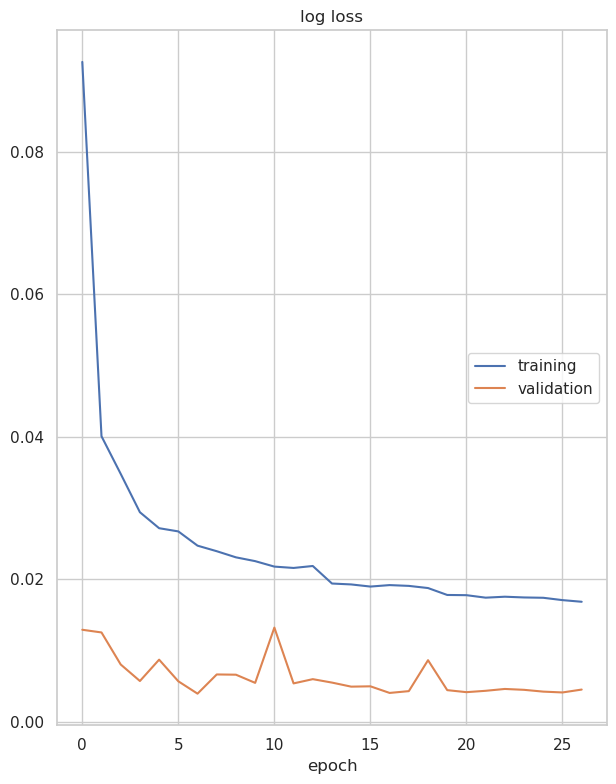

 14%|█▎        | 27/200 [01:09<07:52,  2.73s/it]

log loss
	training         	 (min:    0.017, max:    0.093, cur:    0.017)
	validation       	 (min:    0.004, max:    0.013, cur:    0.004)


 14%|█▎        | 27/200 [01:11<07:37,  2.65s/it]

Early stopping triggered


In [48]:
patience = 20
best_val_loss = float("inf")
patience_counter = 0

liveloss = PlotLosses()
for epoch in tqdm(range(n_epochs)):
    logs = {}

    train_loss = train(model, optimizer, criterion, train_loader)
    logs["" + 'log loss'] = train_loss.item()

    val_loss = validate(model, criterion, val_loader)
    logs["val_" + 'log loss'] = val_loss.item()

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(model_path, "model.pth"))
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter > patience:
            print("Early stopping triggered")
            break

    liveloss.update(logs)
    liveloss.draw()

# **Anomaly Detection**

In [29]:
model.eval()
with torch.no_grad():
    reconstructed = model(data_tensor)  # Perform inference on the entire dataset
    reconstruction_error = torch.mean((reconstructed - data_tensor) ** 2, dim=1)

In [30]:
# Move back to CPU for further processing if necessary
reconstruction_error = reconstruction_error.cpu().numpy()

threshold = np.percentile(reconstruction_error[labels == 1], 97)
print(f'Anomaly threshold: {threshold:.6f}')

anomalies = reconstruction_error > threshold
data['Reconstruction Error'] = reconstruction_error
data['Anomaly'] = anomalies.astype(int)

print(f'Number of anomalies detected: {data["Anomaly"].sum()}')

Anomaly threshold: 0.020568
Number of anomalies detected: 5495


# **Visualization**

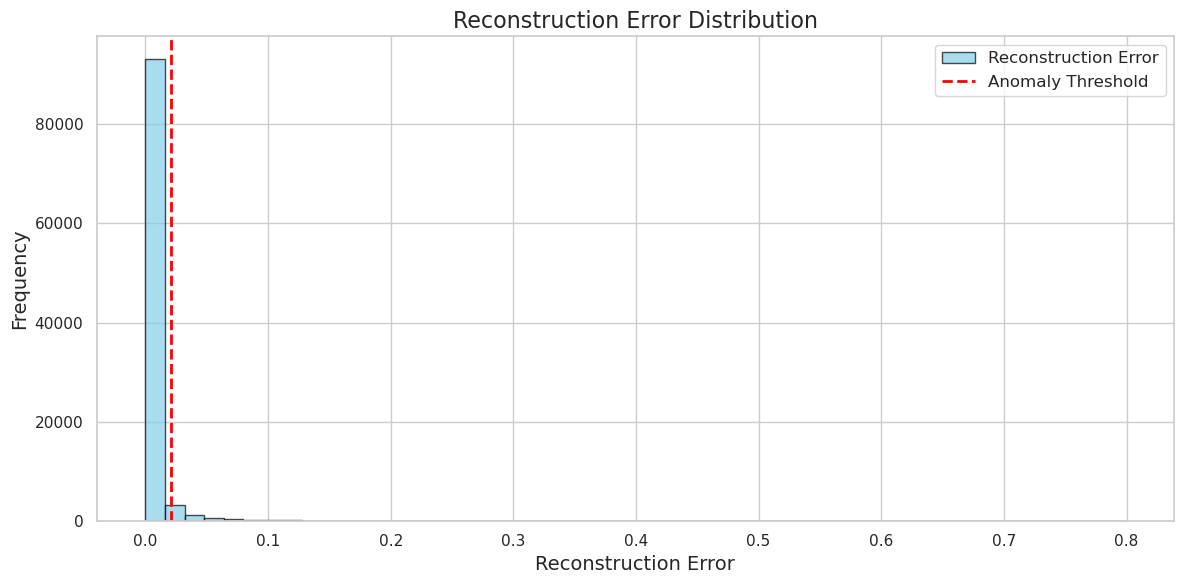

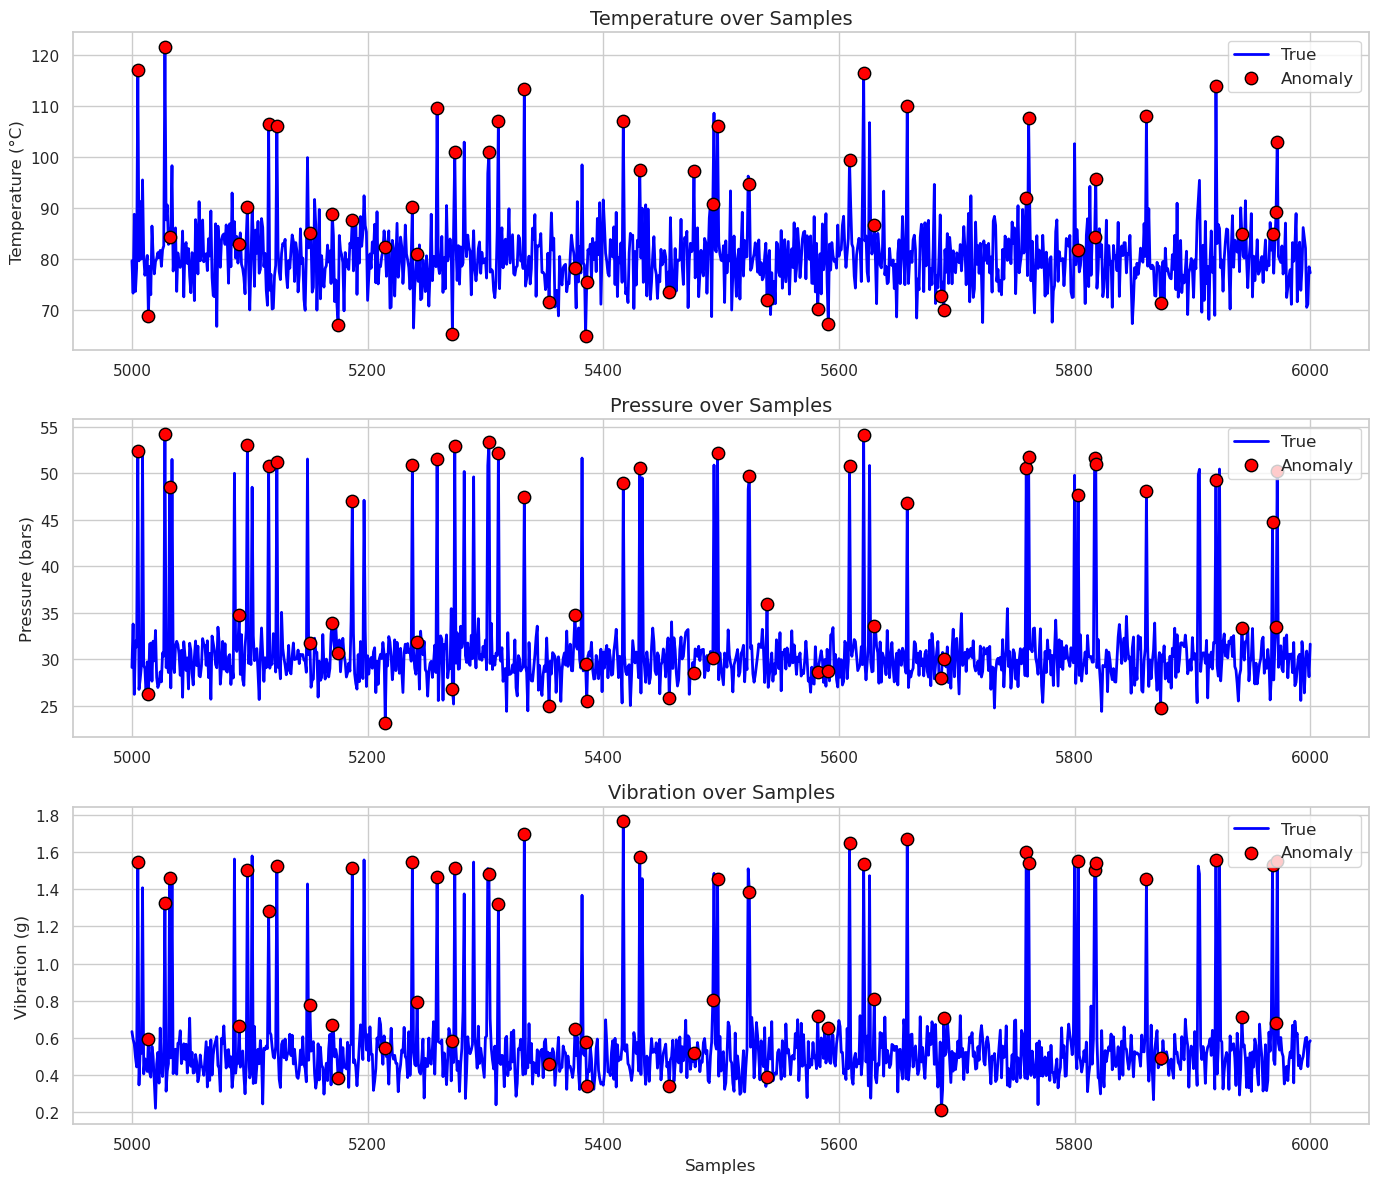

In [33]:
# Set a style for the plots
sns.set(style="whitegrid")

# Plot: Reconstruction Error Distribution
plt.figure(figsize=(12, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.7, color='skyblue', edgecolor='black', label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Anomaly Threshold', lw=2)
plt.title('Reconstruction Error Distribution', fontsize=16)
plt.xlabel('Reconstruction Error', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plot: Anomalies in Time-Series Data with units
features = ['temperature', 'pressure', 'vibration']
units = ['°C', 'bars', 'g']  # Units for each feature
fig, axs = plt.subplots(len(features), 1, figsize=(14, 12))  # Increased size for readability
sample = data.loc[5000:6000]  # Subset of data for plotting

for i, feature in enumerate(features):
    axs[i].plot(sample.index, sample[feature], label='True', color='blue', lw=2)  # Thicker line for true data
    axs[i].scatter(
        sample.index[sample['Anomaly'] == 1],
        sample.loc[sample['Anomaly'] == 1, feature],
        color='red', s=80, edgecolor='black', zorder=5, label='Anomaly'  # Larger, better-defined anomaly points
    )
    axs[i].set_title(f'{feature.capitalize()} over Samples', fontsize=14)  # Capitalize the feature names
    axs[i].legend(fontsize=12, loc='upper right')
    axs[i].set_ylabel(f'{feature.capitalize()} ({units[i]})', fontsize=12)  # Add units to y-axis labels

plt.xlabel('Samples', fontsize=12)
plt.tight_layout()
plt.show()